# g:Profiler Conversion

Lorem ipsum...

In [22]:
import re

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from loguru import logger
from tqdm import tqdm

from philharmonic.utils import (
    load_cluster_json,
    parse_GO_database,
    plot_cluster,
    print_cluster,
)

In [2]:
# Initial Files
cluster_file_path = "/home/ssledzieski/philharmonic_results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.functional.json"
network_file_path = "/home/ssledzieski/philharmonic_results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_network.positive.tsv"
go_map_path = "/home/ssledzieski/philharmonic_results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_GO_map.csv"

GO_DB = "/home/ssledzieski/philharmonic_results/p_damicornis/20240917-pdamAll-phil_v0.3.0/go.obo"

---

## Load Files

In [3]:
cluster_dict = load_cluster_json(cluster_file_path)
go_database = parse_GO_database(GO_DB)
full_G = nx.read_weighted_edgelist(network_file_path, delimiter="\t")

---

## Map to g:Profiler LOC IDs

- Download reference Ensembl genome
    ```bash
    $ wget  http://ftp.ensemblgenomes.org/pub/metazoa/release-59/fasta/pocillopora_damicornis_gca003704095v1/pep/Pocillopora_damicornis_gca003704095v1.ASM370409v1.pep.all.fa
    ```

- Create BLAST database
    ```bash
    $ makeblastdb -dbtype prot -title pdam_loc_db Pocillopora_damicornis_gca003704095v1.ASM370409v1.pep.all.fa
    ```

- Search against BLAST db
    ```bash
    $ ...
    ```

In [4]:
pdam_ensembl_fasta = "/home/ssledzieski/philharmonic_results/p_damicornis/20240930-gProfiler/Pocillopora_damicornis_gca003704095v1.ASM370409v1.pep.all.fa"
pdam_blast_results = "/home/ssledzieski/philharmonic_results/p_damicornis/20240930-gProfiler/pdam_loc_blast_results.tsv"

In [5]:
blast_results = (
    pd.read_csv(pdam_blast_results, sep="\t", header=None)
    .sort_values(0)
    .drop_duplicates([0, 1])
    .set_index(0)
)
blast_results = blast_results[blast_results[10] < 1e-5]
logger.info(f"{len(blast_results)} hits with e-value < 1e-5")
logger.info(f"{len(blast_results[1].unique())} unique hits")

2024-09-30 10:59:09.542 | INFO     | __main__:<module>:3 - 21894 hits with e-value < 1e-5
2024-09-30 10:59:09.547 | INFO     | __main__:<module>:4 - 17436 unique hits


In [6]:
blast_results.head()

,1,2,3,4,5,6,7,8,9,10,11
0,,,,,,,,,,,
pdam_00000001-RA,XP_027056588.1,100.000,360,0,0,1,360,31,390,0.000000e+00,737.0
pdam_00000002-RA,XP_027056458.1,93.440,747,14,2,1,712,13,759,0.000000e+00,1417.0
pdam_00000003-RA,XP_027056664.1,100.000,333,0,0,1,333,1,333,0.000000e+00,701.0
pdam_00000005-RA,XP_027056460.1,71.429,63,18,0,1,63,170,232,2.550000e-27,102.0
pdam_00000006-RA,XP_027056665.1,88.066,243,29,0,1,243,1,243,2.120000e-159,446.0


In [7]:
pep_fasta = SeqIO.to_dict(SeqIO.parse(pdam_ensembl_fasta, "fasta"))

REGEXP = ".*gene:(LOC\\d+) .*"
regcomp = re.compile(REGEXP)

xp_loc_map = {}
for k, v in pep_fasta.items():
    try:
        locid = regcomp.search(v.description).group(1)
        xp_loc_map[k] = locid
    except AttributeError:
        logger.warning(f"No match for {v.name}")

2024-09-30 10:59:10.155 | WARNING  | __main__:<module>:14 - No match for YP_001456710.1
2024-09-30 10:59:10.159 | WARNING  | __main__:<module>:14 - No match for YP_001456705.1
2024-09-30 10:59:10.161 | WARNING  | __main__:<module>:14 - No match for YP_001456711.1
2024-09-30 10:59:10.164 | WARNING  | __main__:<module>:14 - No match for YP_001456716.1
2024-09-30 10:59:10.165 | WARNING  | __main__:<module>:14 - No match for YP_001456704.1
2024-09-30 10:59:10.166 | WARNING  | __main__:<module>:14 - No match for YP_001456712.1
2024-09-30 10:59:10.167 | WARNING  | __main__:<module>:14 - No match for YP_001456714.1
2024-09-30 10:59:10.167 | WARNING  | __main__:<module>:14 - No match for YP_001456703.1
2024-09-30 10:59:10.168 | WARNING  | __main__:<module>:14 - No match for YP_001456708.1
2024-09-30 10:59:10.171 | WARNING  | __main__:<module>:14 - No match for YP_001456707.1
2024-09-30 10:59:10.171 | WARNING  | __main__:<module>:14 - No match for YP_001456706.1
2024-09-30 10:59:10.176 | WARNIN

---

## View g:Profiler Enrichment for a cluster

In [24]:
from gprofiler import GProfiler

gp = GProfiler(
    user_agent="ExampleTool",  # optional user agent
    return_dataframe=True,  # return pandas dataframe or plain python structures
)
PDAM_ORGANISM = "pdgca003704095v1"

In [25]:
def cluster_name_map(c, blast_map, loc_map):
    mapped_names = []
    for pdam_id in c["members"]:
        try:
            mapped_names.append(loc_map[blast_map.loc[pdam_id, 1]])
        except (KeyError, IndexError):
            logger.warning(f"{pdam_id} had no match in blast results")
    return mapped_names

In [31]:
logger.disable("__main__")
for k, cl in tqdm(cluster_dict.items(), total=len(cluster_dict)):
    cl["members_loc"] = cluster_name_map(cl, blast_results, xp_loc_map)
    cl["gprofiler"] = gp.profile(
        organism=PDAM_ORGANISM, query=cl["members_loc"], sources=["GO:BP"]
    )
logger.enable("__main__")
logger.info("Added gprofile annotations")

100%|██████████| 610/610 [04:21<00:00,  2.33it/s]
2024-09-30 13:41:59.515 | INFO     | __main__:<module>:6 - Added gprofile annotations


In [61]:
# chash = "549662403768153899"
chash = list(cluster_dict.keys())[55]
selected_cluster = cluster_dict[chash]

In [67]:
print_cluster(selected_cluster, go_database, n_terms=20)

Cluster of 26 proteins [pdam_00006910-RA, pdam_00010978-RA, pdam_00014352-RA, ...] (hash 1465385134216941027)
20 proteins re-added by ReCIPE (degree, 0.75)
Edges: 29
Triangles: 6
Max Degree: 8
Top Terms:
		GO:0003416 - <endochondral bone growth> (26)
		GO:0048846 - <axon extension involved in axon guidance> (26)
		GO:0042748 - <circadian sleep/wake cycle, non-REM sleep> (26)
		GO:0097374 - <sensory neuron axon guidance> (26)
		GO:0021761 - <limbic system development> (26)
		GO:1903375 - <facioacoustic ganglion development> (26)
		GO:0005975 - <carbohydrate metabolic process> (26)
		GO:0021785 - <branchiomotor neuron axon guidance> (26)
		GO:1900242 - <regulation of synaptic vesicle endocytosis> (26)
		GO:0097490 - <sympathetic neuron projection extension> (26)
		GO:0061441 - <renal artery morphogenesis> (26)
		GO:0030913 - <paranodal junction assembly> (26)
		GO:0036486 - <ventral trunk neural crest cell migration> (26)
		GO:0001868 - <regulation of complement activation, lectin pathwa

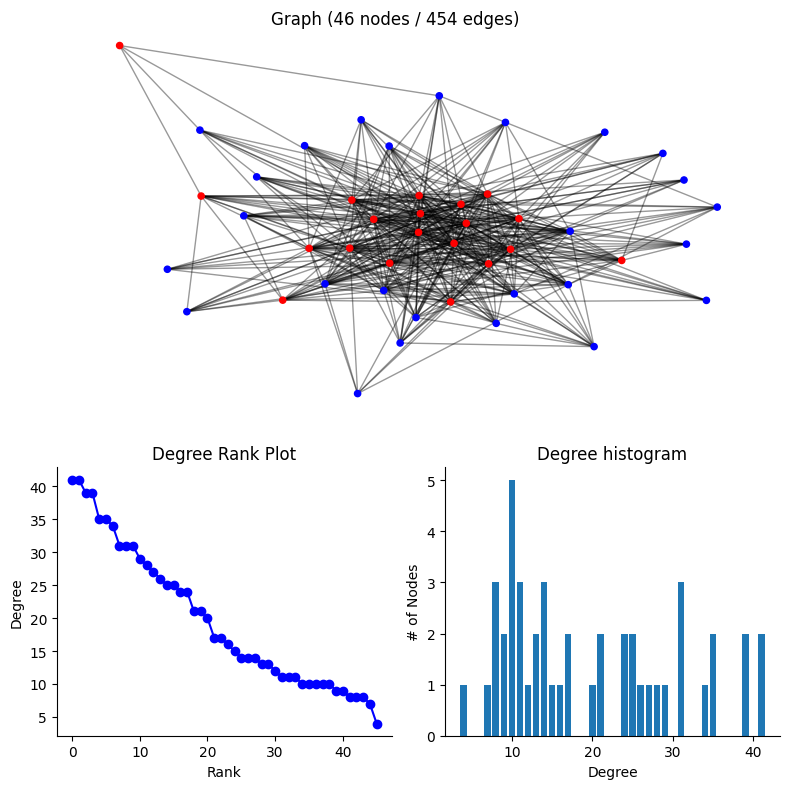

In [68]:
plot_cluster(selected_cluster, full_G)

In [69]:
selected_cluster["gprofiler"]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0007399,nervous system development,0.002011,True,"""The process whose specific outcome is the pro...",68,7,3,8782,0.428571,0.044118,query_1,[GO:0048731]
1,GO:BP,GO:0030154,cell differentiation,0.003940,True,"""The cellular developmental process in which a...",85,7,3,8782,0.428571,0.035294,query_1,[GO:0048869]
2,GO:BP,GO:0048869,cellular developmental process,0.004081,True,"""A biological process whose specific outcome i...",86,7,3,8782,0.428571,0.034884,query_1,"[GO:0009987, GO:0032502]"
3,GO:BP,GO:0048731,system development,0.004836,True,"""The process whose specific outcome is the pro...",91,7,3,8782,0.428571,0.032967,query_1,"[GO:0007275, GO:0048856]"
4,GO:BP,GO:0007275,multicellular organism development,0.015039,True,"""The biological process whose specific outcome...",133,7,3,8782,0.428571,0.022556,query_1,"[GO:0032501, GO:0048856]"
5,GO:BP,GO:0006968,cellular defense response,0.026964,True,"""A defense response that is mediated by cells....",28,7,2,8782,0.285714,0.071429,query_1,[GO:0006952]
6,GO:BP,GO:0002697,regulation of immune effector process,0.026964,True,"""Any process that modulates the frequency, rat...",28,7,2,8782,0.285714,0.071429,query_1,"[GO:0002252, GO:0002682]"
7,GO:BP,GO:0010185,regulation of cellular defense response,0.026964,True,"""Any process that modulates the frequency, rat...",28,7,2,8782,0.285714,0.071429,query_1,"[GO:0006968, GO:0031347]"
8,GO:BP,GO:0030449,regulation of complement activation,0.026964,True,"""Any process that modulates the frequency, rat...",28,7,2,8782,0.285714,0.071429,query_1,"[GO:0002697, GO:0002920, GO:0006956]"
9,GO:BP,GO:0001868,"regulation of complement activation, lectin pa...",0.026964,True,"""Any process that modulates the frequency, rat...",28,7,2,8782,0.285714,0.071429,query_1,"[GO:0001867, GO:0030449, GO:0045088]"
